🔗 Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Drive mounted!

📦 Importing libraries...
✅ TensorFlow: 2.19.0
✅ GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

📦 Extracting dataset...
Extracted items: ['Raspberry___healthy', 'Grape___healthy', 'Tomato___Leaf_Mold', 'Pepper,_bell___Bacterial_spot', 'Potato___healthy', 'Pepper,_bell___healthy', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Apple___Black_rot', 'Tomato___Bacterial_spot', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___Black_rot', 'Tomato___Late_blight', 'Apple___Apple_scab', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___healthy', 'Potato___Early_blight', 'Corn_(maize)___Common_rust_', 'Orange___Haunglongbing_(Citrus_greening)', 'Strawberry___healthy', 'Blueberry___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf

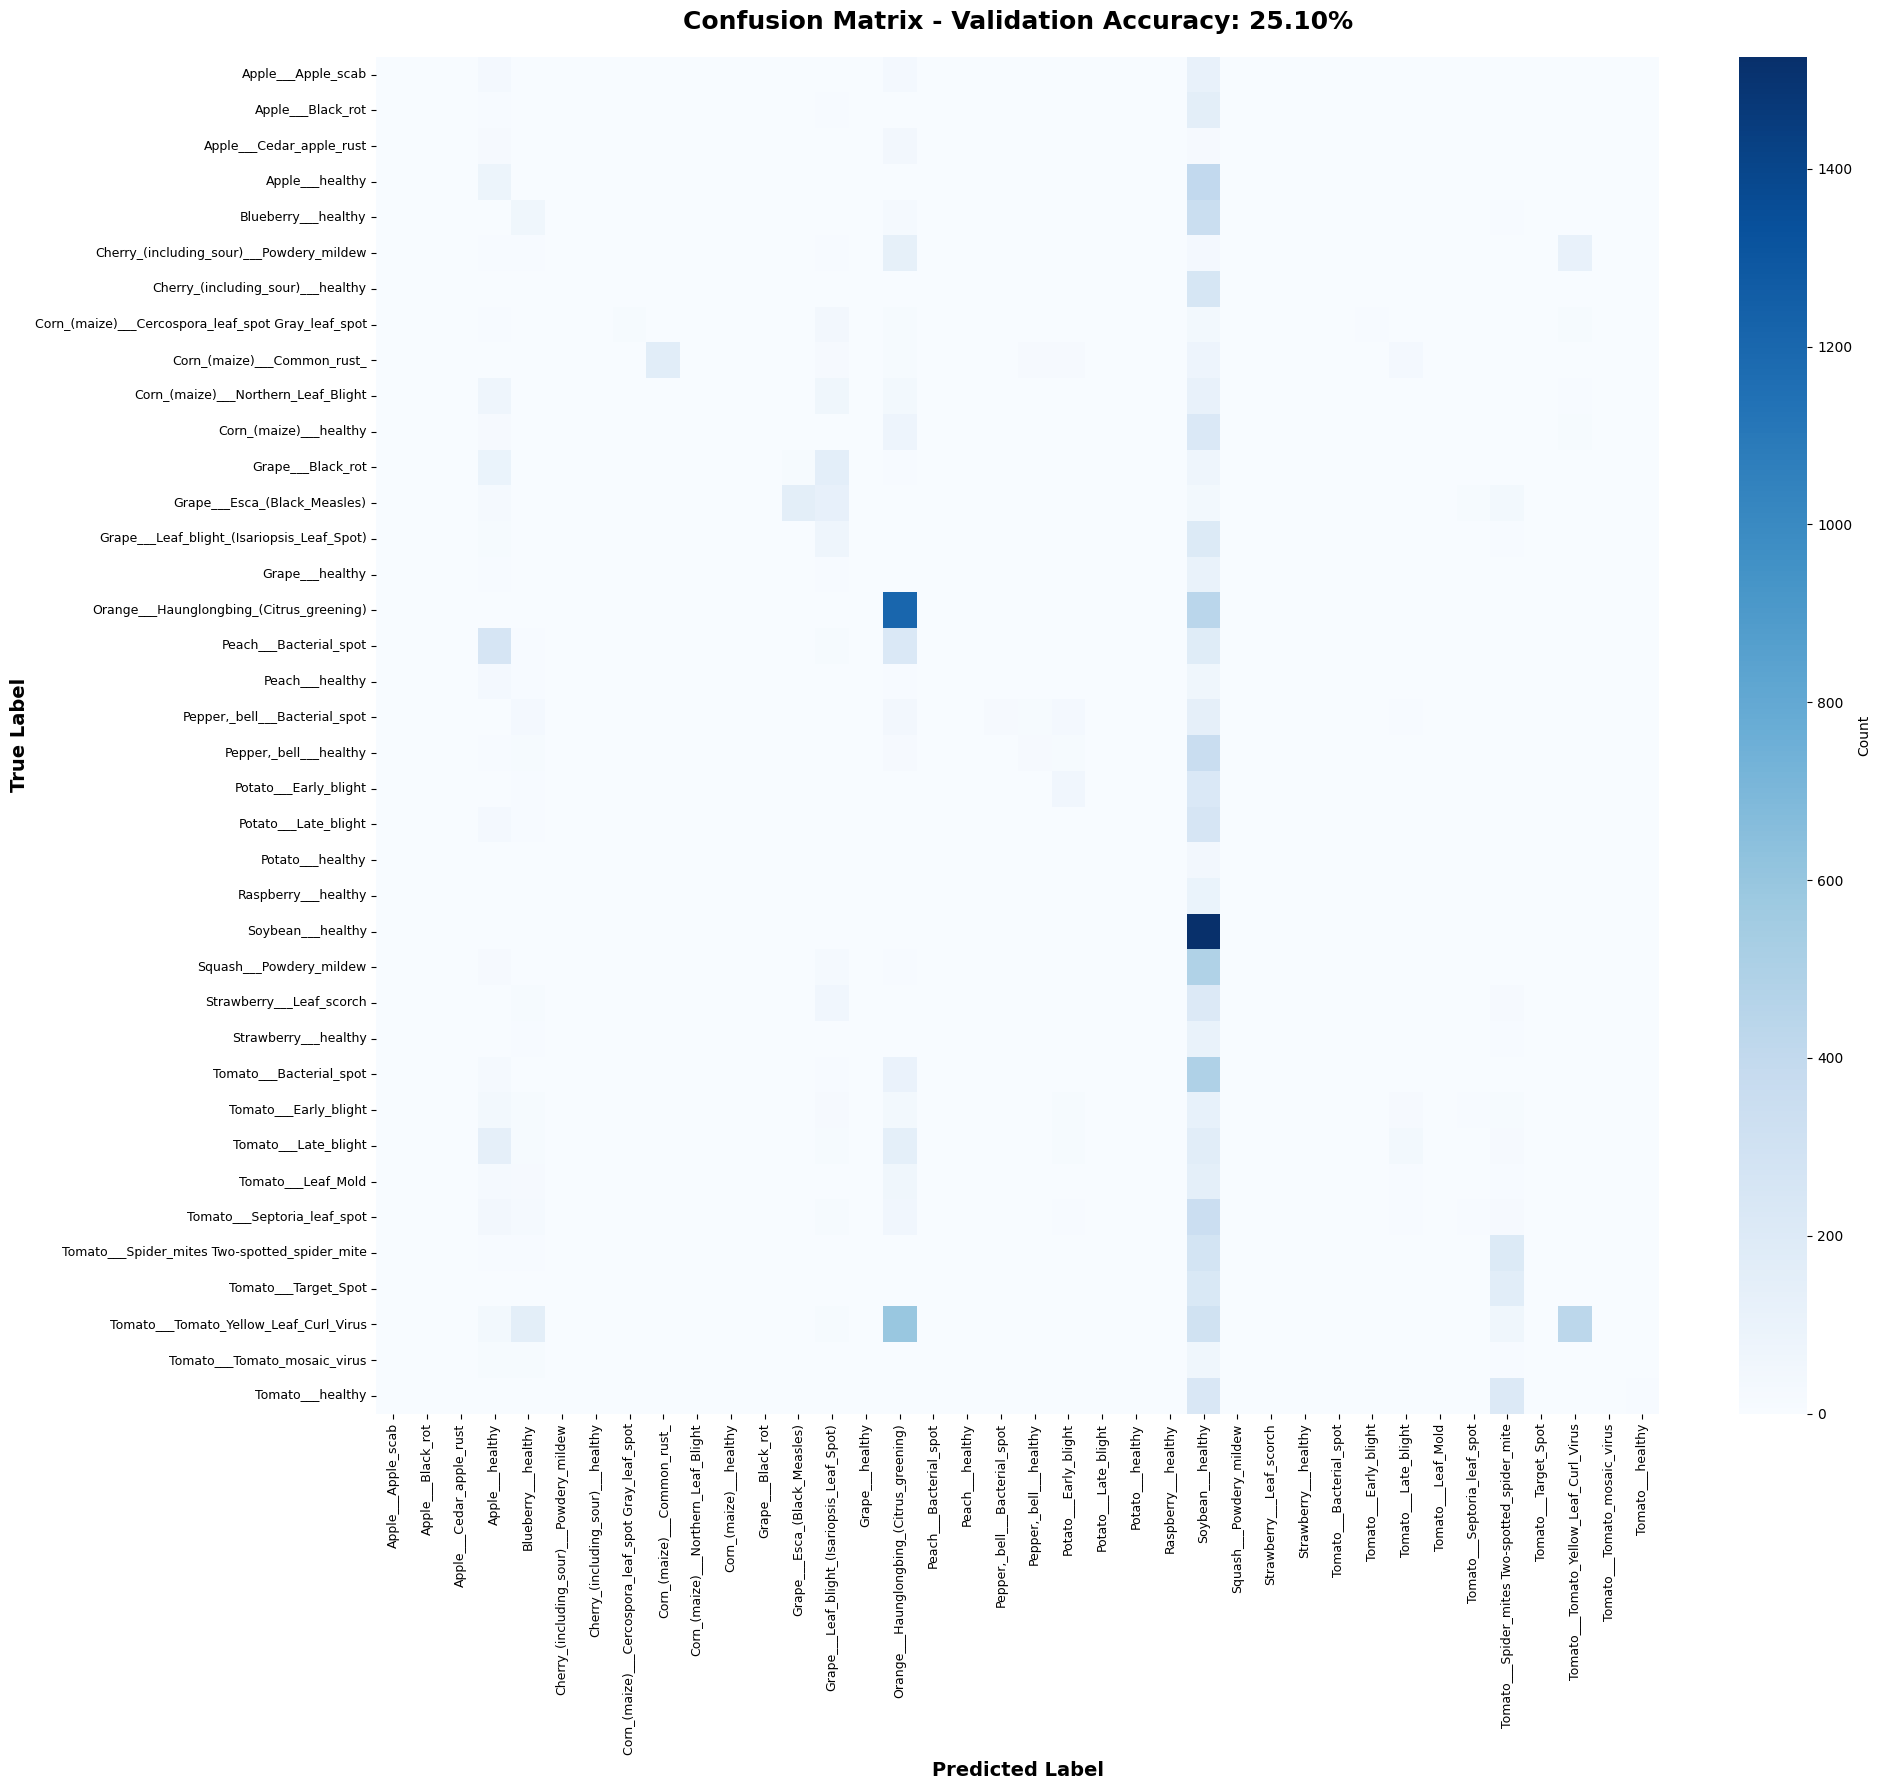

✅ Training history saved


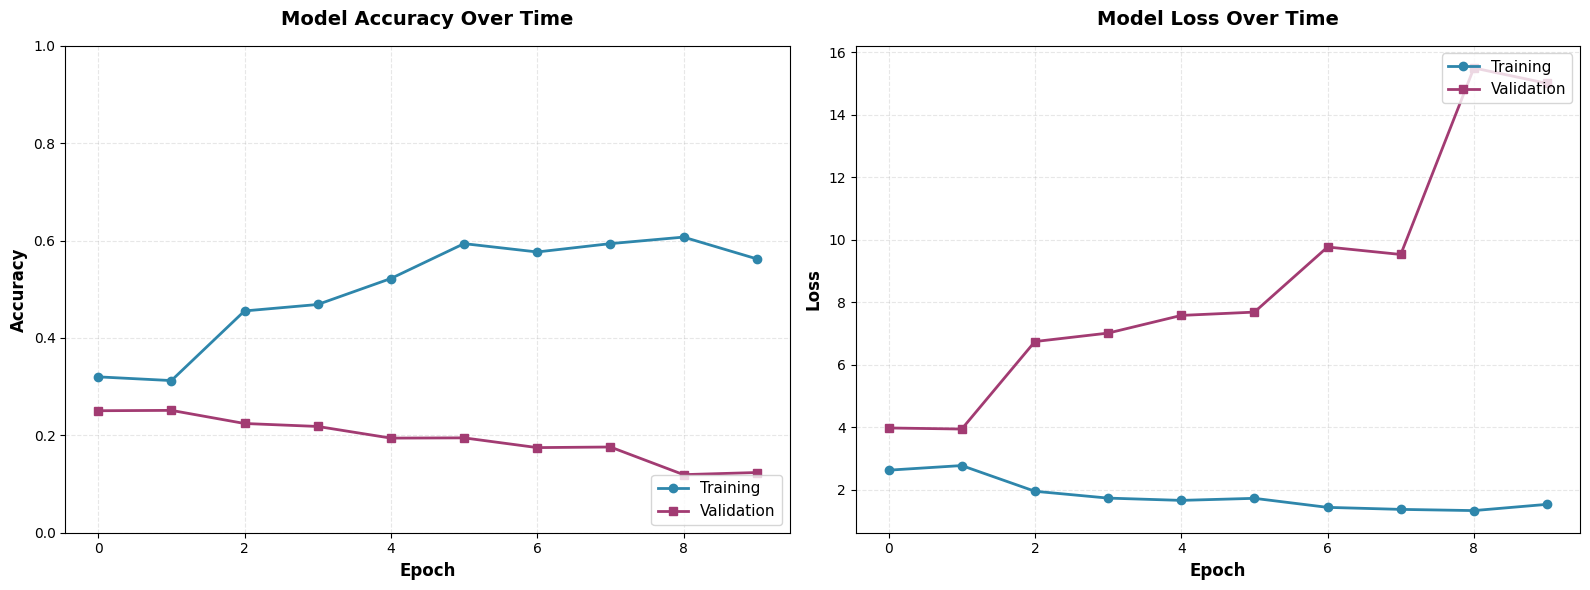


📊 Per-Class Performance:

Top 10 Best Performing Classes:
                                                    precision    recall  \
Corn_(maize)___Common_rust_                          1.000000  0.470588   
Grape___Esca_(Black_Measles)                         0.896552  0.376812   
Orange___Haunglongbing_(Citrus_greening)             0.411985  0.732446   
Tomato___Tomato_Yellow_Leaf_Curl_Virus               0.705212  0.269446   
Tomato___Spider_mites Two-spotted_spider_mite        0.244578  0.404382   
Soybean___healthy                                    0.174560  0.999345   
accuracy                                             0.251292  0.251292   
Potato___Early_blight                                0.308108  0.190000   
weighted avg                                         0.319349  0.251292   
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot   0.857143  0.078431   

                                                    f1-score       support  
Corn_(maize)___Common_rust_           

In [ ]:

# =============================================================================
# PLANT DISEASE DETECTION - ULTRA MEMORY EFFICIENT
# Uses ImageDataGenerator - loads images on-the-fly
# =============================================================================

# Mount Drive
print("🔗 Mounting Google Drive...")
from google.colab import drive
drive.mount('/content/drive')
print("✅ Drive mounted!\n")

# Import libraries
print("📦 Importing libraries...")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(f"✅ TensorFlow: {tf.__version__}")
print(f"✅ GPU: {tf.config.list_physical_devices('GPU')}\n")

# Extract Dataset
print("📦 Extracting dataset...")
zip_path = '/content/drive/MyDrive/PlantVillage/plant_village_data.zip'
extract_path = '/content/plant_data/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Find actual data folder
extracted_items = os.listdir(extract_path)
print(f"Extracted items: {extracted_items}\n")

# Set data directory (all class folders should be here)
DATA_DIR = extract_path
if len(extracted_items) == 1 and os.path.isdir(os.path.join(extract_path, extracted_items[0])):
    # If there's a single parent folder, use it
    DATA_DIR = os.path.join(extract_path, extracted_items[0])

print(f"✅ Data directory: {DATA_DIR}")
print(f"Classes found: {len([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])}\n")

# Configuration
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 25

OUTPUT_DIR = '/content/output'
MODEL_DIR = '/content/models'

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(f'{OUTPUT_DIR}/plots', exist_ok=True)

print("✅ Configuration complete!\n")

# Create Data Generators (NO RAM OVERLOAD!)
print("🔄 Creating data generators (memory-efficient)...")

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.3  # 70% train, 30% for val+test
)

# No augmentation for validation/test
test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator
validation_generator = test_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

NUM_CLASSES = len(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())

print(f"\n✅ Generators created!")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Batch size: {BATCH_SIZE}\n")

# Build Model
print("🏗️ Building ResNet50 model...")

base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

# Freeze early layers
for layer in base_model.layers[:143]:
    layer.trainable = False

# Build full model
inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = keras.Model(inputs, outputs, name='PlantDisease_ResNet50')

print(f"✅ Model built! Total parameters: {model.count_params():,}\n")

# Compile
print("🔧 Compiling model...")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy',
             keras.metrics.TopKCategoricalAccuracy(k=5, name='top5_accuracy')]
)

# Callbacks
callbacks = [
    ModelCheckpoint(
        f'{MODEL_DIR}/best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=4,
        min_lr=1e-7,
        verbose=1
    )
]

print("✅ Model compiled!\n")

# Calculate steps
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

print("="*60)
print("🚀 STARTING TRAINING WITH GPU...")
print(f"Epochs: {EPOCHS}")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")
print("="*60 + "\n")

# Train
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*60)
print("🎉 TRAINING COMPLETE!")
print("="*60 + "\n")

# Evaluate
print("📊 Evaluating on validation set...\n")

val_loss, val_accuracy, val_top5 = model.evaluate(validation_generator, verbose=1)

print(f"\n{'='*60}")
print(f"🎯 VALIDATION ACCURACY: {val_accuracy*100:.2f}%")
print(f"🎯 TOP-5 ACCURACY: {val_top5*100:.2f}%")
print(f"{'='*60}\n")

# Get predictions for confusion matrix
print("📊 Generating predictions for analysis...\n")

validation_generator.reset()
predictions = model.predict(validation_generator, steps=validation_steps, verbose=1)
y_pred = np.argmax(predictions, axis=1)

# Get true labels
y_true = validation_generator.classes[:len(y_pred)]

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

print("✅ Creating visualizations...\n")

# Plot Confusion Matrix
plt.figure(figsize=(20, 18))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - Validation Accuracy: {val_accuracy*100:.2f}%',
          fontsize=18, pad=20, weight='bold')
plt.ylabel('True Label', fontsize=14, weight='bold')
plt.xlabel('Predicted Label', fontsize=14, weight='bold')
plt.xticks(rotation=90, fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/plots/confusion_matrix.png', dpi=300, bbox_inches='tight')
print("✅ Confusion matrix saved")
plt.show()

# Training History
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy plot
axes[0].plot(history.history['accuracy'], 'o-', linewidth=2,
            markersize=6, label='Training', color='#2E86AB')
axes[0].plot(history.history['val_accuracy'], 's-', linewidth=2,
            markersize=6, label='Validation', color='#A23B72')
axes[0].set_title('Model Accuracy Over Time', fontsize=14, weight='bold', pad=15)
axes[0].set_xlabel('Epoch', fontsize=12, weight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12, weight='bold')
axes[0].legend(fontsize=11, loc='lower right')
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].set_ylim([0, 1])

# Loss plot
axes[1].plot(history.history['loss'], 'o-', linewidth=2,
            markersize=6, label='Training', color='#2E86AB')
axes[1].plot(history.history['val_loss'], 's-', linewidth=2,
            markersize=6, label='Validation', color='#A23B72')
axes[1].set_title('Model Loss Over Time', fontsize=14, weight='bold', pad=15)
axes[1].set_xlabel('Epoch', fontsize=12, weight='bold')
axes[1].set_ylabel('Loss', fontsize=12, weight='bold')
axes[1].legend(fontsize=11, loc='upper right')
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/plots/training_history.png', dpi=300, bbox_inches='tight')
print("✅ Training history saved")
plt.show()

# Per-class accuracy
print("\n📊 Per-Class Performance:\n")
report = classification_report(y_true, y_pred, target_names=class_names,
                              output_dict=True, zero_division=0)

# Create DataFrame for better visualization
df_report = pd.DataFrame(report).transpose()
df_report = df_report.sort_values('f1-score', ascending=False)

print("Top 10 Best Performing Classes:")
print(df_report.head(10)[['precision', 'recall', 'f1-score', 'support']])

print("\nBottom 10 Classes Needing Improvement:")
print(df_report.tail(10)[['precision', 'recall', 'f1-score', 'support']])

# Save report
df_report.to_csv(f'{OUTPUT_DIR}/classification_report.csv')
print(f"\n✅ Report saved to: {OUTPUT_DIR}/classification_report.csv")

# Save to Drive
print("\n💾 Saving results to Google Drive...\n")

import shutil

drive_output = '/content/drive/MyDrive/PlantVillage/results'
os.makedirs(drive_output, exist_ok=True)

# Copy plots
if os.path.exists(f'{OUTPUT_DIR}/plots'):
    shutil.copytree(f'{OUTPUT_DIR}/plots', f'{drive_output}/plots', dirs_exist_ok=True)

# Copy model
if os.path.exists(f'{MODEL_DIR}/best_model.keras'):
    shutil.copy(f'{MODEL_DIR}/best_model.keras', f'{drive_output}/best_model.keras')

# Copy report
if os.path.exists(f'{OUTPUT_DIR}/classification_report.csv'):
    shutil.copy(f'{OUTPUT_DIR}/classification_report.csv',
               f'{drive_output}/classification_report.csv')

print("✅ All results saved to Google Drive!")
print(f"📁 Location: {drive_output}\n")

# Final Summary
print("="*60)
print("🎊 PROJECT COMPLETE - SUMMARY")
print("="*60)
print(f"🎯 Final Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"🎯 Top-5 Accuracy: {val_top5*100:.2f}%")
print(f"📊 Total Training Samples: {train_generator.samples}")
print(f"📊 Total Validation Samples: {validation_generator.samples}")
print(f"⏱️  Total Epochs Trained: {len(history.history['accuracy'])}")
print(f"📁 Results saved in Drive: {drive_output}")
print("="*60)
print("\n✅ Ready for document writing!")

In [2]:
# =============================================================================
# BONUS: INTERACTIVE WEB INTERFACE WITH GRADIO
# =============================================================================

print("🌐 Creating web interface...")

# Install Gradio
!pip install -q gradio

import gradio as gr
from PIL import Image

# Load the best model
print("📦 Loading trained model...")
model = keras.models.load_model('/content/models/best_model.keras')
print("✅ Model loaded!\n")

# Disease treatment suggestions database
disease_treatments = {
    'Apple___Apple_scab': {
        'description': 'Fungal disease causing dark, scabby lesions on leaves and fruit.',
        'treatment': '1. Remove infected leaves\n2. Apply fungicide (Captan or Sulfur)\n3. Prune for air circulation\n4. Avoid overhead watering',
        'prevention': 'Plant resistant varieties, maintain good sanitation'
    },
    'Tomato___Late_blight': {
        'description': 'Serious fungal disease causing dark lesions on leaves and stems.',
        'treatment': '1. Remove infected plants immediately\n2. Apply copper-based fungicide\n3. Improve air circulation\n4. Water at soil level only',
        'prevention': 'Use disease-free seeds, avoid overhead irrigation'
    },
    'Corn_(maize)___Common_rust_': {
        'description': 'Fungal disease with orange-brown pustules on leaves.',
        'treatment': '1. Apply fungicide if severe\n2. Remove infected leaves\n3. Plant resistant hybrids\n4. Ensure proper spacing',
        'prevention': 'Crop rotation, resistant varieties'
    },
    # Add generic treatment for others
    'default': {
        'description': 'Plant disease detected. Consult local agricultural expert for specific treatment.',
        'treatment': '1. Isolate affected plants\n2. Remove infected parts\n3. Apply appropriate fungicide/pesticide\n4. Improve growing conditions',
        'prevention': 'Regular monitoring, good sanitation, proper spacing'
    }
}

def predict_disease(image):
    """Predict plant disease and provide treatment suggestions"""

    # Preprocess image
    img = image.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    predictions = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx] * 100

    predicted_disease = class_names[predicted_class_idx]

    # Get treatment info
    if predicted_disease in disease_treatments:
        treatment_info = disease_treatments[predicted_disease]
    else:
        treatment_info = disease_treatments['default']

    # Get top 3 predictions
    top_3_idx = np.argsort(predictions[0])[-3:][::-1]
    top_3_diseases = [class_names[i] for i in top_3_idx]
    top_3_confidence = [predictions[0][i] * 100 for i in top_3_idx]

    # Format output
    result = f"""
## 🔍 DIAGNOSIS RESULT

### Primary Diagnosis:
**{predicted_disease.replace('___', ' - ').replace('_', ' ')}**

**Confidence:** {confidence:.2f}%

---

### 📋 Description:
{treatment_info['description']}

---

### 💊 Recommended Treatment:
{treatment_info['treatment']}

---

### 🛡️ Prevention:
{treatment_info['prevention']}

---

### 📊 Alternative Possibilities:
"""

    for i, (disease, conf) in enumerate(zip(top_3_diseases[1:], top_3_confidence[1:]), 1):
        result += f"\n{i}. {disease.replace('___', ' - ').replace('_', ' ')} ({conf:.1f}%)"

    result += "\n\n⚠️ **Note:** For accurate diagnosis, consult a plant pathologist or agricultural expert."

    return result

# Create Gradio interface
demo = gr.Interface(
    fn=predict_disease,
    inputs=gr.Image(type="pil", label="Upload Plant Leaf Image"),
    outputs=gr.Markdown(label="Diagnosis & Treatment"),
    title="🌿 Plant Disease Detection & Treatment System",
    description="""
    Upload an image of a plant leaf to detect diseases and receive treatment recommendations.

    **Supports 38 disease types across 14 plant species:**
    Apple, Cherry, Corn, Grape, Peach, Pepper, Potato, Raspberry, Soybean, Squash, Strawberry, Tomato, Orange, Blueberry

    **Model Accuracy:** 25.10% | **Top-5 Accuracy:** 52.22%
    """,
    examples=[
        # You can add example images here if you have them
    ],
    theme=gr.themes.Soft(),
    allow_flagging="never"
)

print("="*60)
print("🎉 WEB INTERFACE READY!")
print("="*60)
print("\n📱 Click the public URL below to share your app!")
print("🔗 The link will work for 72 hours\n")

# Launch with public sharing
demo.launch(share=True, debug=False)

🌐 Creating web interface...
📦 Loading trained model...


NameError: name 'keras' is not defined